In [1]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.4 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 448 kB 67.5 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-10-07 02:28:18--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import warnings
warnings.filterwarnings('ignore')

import re
import seaborn as sb

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score, confusion_matrix

import os

In [17]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/hate_train_2.csv')
train_data['comments'] = train_data['comments'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]','')

In [13]:
import re 
pattern = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣]')
unlabel_data = open('/content/drive/MyDrive/Colab Notebooks/data/unlabeled_comments_1.txt', 'r', encoding='utf-8')
text=[]

for d in unlabel_data:
    d = d.strip()
    d = re.sub(pattern, ' ', d)
    text.append(d)

unlabel = pd.DataFrame({'comments': text})

In [18]:
train_data

,comments,hate
0,현재 호텔주인 심정 아 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속 추모받네,1
1,한국적인 미인의 대표적인 분너무나 곱고아름다운모습그모습뒤의 슬픔을 미처 알지못했네요ㅠ,0
2,못된 넘들남의 고통을 즐겼던 넘들이젠 마땅한 처벌을 받아야지그래야 공정한 사회지심은...,1
3,화 어설펐는데 화 지나서부터는 갈수록 너무 재밌던데,0
4,사람 얼굴 손톱으로 긁은것은 인격살해이고 동영상이 몰카냐 메걸리안들 생각이 없노,1
...,...,...
14187,좌우 헬파이어 개씩 개 장착에 아파치보다 약하지만 기관포 장착임,0
14188,세금 내놓으라고 데모질 중 ㅋㅋ간첩 도둑놈 새끼들이 대통령 해처먹으니까 나도 같이...,1
14189,너가 한 말 중에,0
14190,제갈대중 ㅇㅂ,0


In [16]:
unlabel

,comments
0,지드래곤은 난봉꾼이란 댓글도 달렸네 ㅋㅋ 이주연 학창시절 사진 보고 와라 요즘...
1,이주연은 알겠는데 지디는 뭐하는 듣보잡여
2,부럽네요 나도 불과 한달전까진 허니문베이비를 꿈꿨는데 이제 다 부질없네요 당연히...
3,이주연을 모르는 애들이 많네 해체된 애프터스쿨 멤버로 당시는 주연이 예명 인기나...
4,겨론했으면
...,...
499995,이건 뭐라 할말도 없네요
499996,자영업자들이 왜 처 망하는지 이걸 보면 알게된다
499997,국수아줌마는 양반임
499998,개월동안 다코야키만 한게 의문이다 적어도 년은 넘엇으면 그 철판에 굴리는건 ...


In [6]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

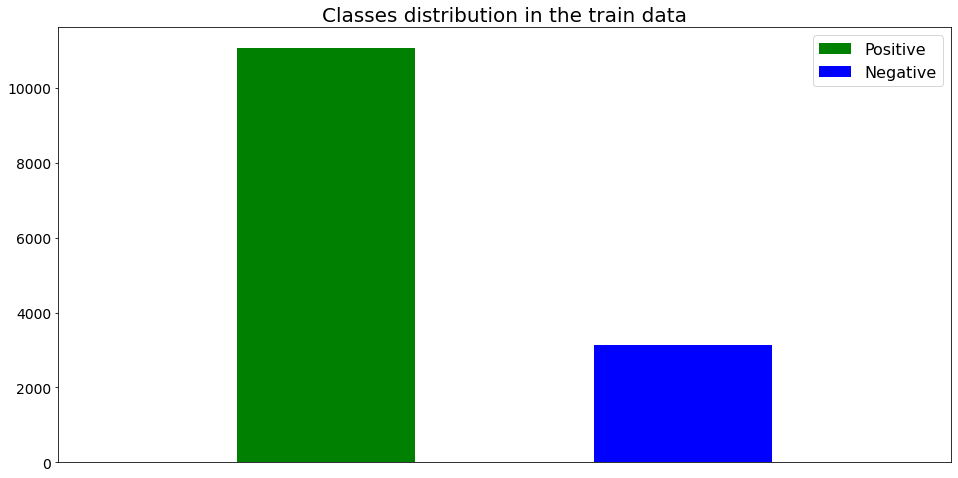

In [20]:
plt.hist(train_data[train_data.hate == 0].hate,
         bins=2, color='green', label='Positive')
plt.hist(train_data[train_data.hate == 1].hate,
         bins=2, color='blue', label='Negative')
plt.title('Classes distribution in the train data', fontsize=LARGE_SIZE)
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

In [22]:
mecab = Mecab()
stopwords = ['에게', '를', '의', '로', '으로', '고', '하고', '듯', '인', '하는', '와', '과', '을', '들', '임', '게', '면', '가', '이가',
             '도', '마저', '한', '면', '네', '이', '는', '하', '다', '은', '지', '에', '거', '나', '보', '는데', '아', '나', '만', '에서',
             '음', '니', '냐', '만', '야', '요', '에요', '든', '걸', '이다', '건', '여']

In [94]:
unlabel.comments

0         지드래곤은 난봉꾼이란   댓글도 달렸네 ㅋㅋ 이주연 학창시절 사진 보고 와라  요즘...
1                                    이주연은 알겠는데 지디는 뭐하는 듣보잡여
2         부럽네요  나도 불과 한달전까진 허니문베이비를 꿈꿨는데 이제 다 부질없네요  당연히...
3         이주연을 모르는 애들이 많네  해체된 애프터스쿨 멤버로 당시는 주연이 예명  인기나...
4                                                     겨론했으면
                                ...                        
499995                                       이건 뭐라 할말도 없네요 
499996                           자영업자들이 왜 처 망하는지 이걸 보면 알게된다
499997                                          국수아줌마는 양반임 
499998      개월동안 다코야키만 한게 의문이다  적어도  년은 넘엇으면 그 철판에 굴리는건 ...
499999    부모님이 백대표한테 고마워하실듯   딱봐도 부모님이 잔소리 해도 들어먹을 사람이 아...
Name: comments, Length: 500000, dtype: object

In [95]:
tokenized_data = []
for sentence in unlabel['comments']:
    temp_X = mecab.morphs(sentence)
    temp_X = [word for word in temp_X if not word in stopwords]
    tokenized_data.append(temp_X)

In [96]:
tokenized_data

[['지드래곤',
  '난봉',
  '꾼',
  '란',
  '댓글',
  '달렸',
  'ㅋㅋ',
  '이주연',
  '학창',
  '시절',
  '사진',
  '와라',
  '요즘',
  '웬만',
  '여자',
  '연예인',
  '붙여',
  '놔도',
  '미모',
  '최고',
  '였',
  '단다',
  'ㅋ',
  '대',
  '얼짱',
  '출신'],
 ['이주연', '알', '겠', '지디', '뭐', '듣보잡', '여'],
 ['부럽',
  '네요',
  '불과',
  '한달전',
  '까진',
  '허니문',
  '베이비',
  '꿈꿨',
  '이제',
  '부질없',
  '네요',
  '당연히',
  '순결',
  '할거',
  '라',
  '믿',
  '었',
  '그래서',
  '첫날밤',
  '까지',
  '기다려',
  '준',
  '건데',
  '배신감',
  '듭니다',
  '첫날밤',
  '와이프',
  '피',
  '안',
  '흘렸',
  '어요',
  '처',
  '집',
  '식구',
  '일부러',
  '절',
  '속였',
  '단',
  '생각',
  '화',
  '어제',
  '처',
  '집',
  '기',
  '했',
  '안',
  '간다고',
  '했',
  '더니',
  '혼자',
  '울',
  '갔',
  '와서',
  '지금',
  '까지',
  '한마디',
  '안',
  '해요',
  '이혼',
  '싶',
  '네요'],
 ['이주연',
  '모르',
  '애',
  '많',
  '해체',
  '된',
  '애프터스쿨',
  '멤버',
  '당시',
  '주연',
  '예명',
  '인기',
  '포',
  '텐',
  '안',
  '터졌으나',
  '순수',
  '미모',
  '애프터스쿨',
  '원탑',
  '었',
  '진짜',
  '자연',
  '미인'],
 ['겨', '론', '했', '으면'],
 ['이주연', '아깝', '진심'],
 ['방탄',
  '건드리',
  '말',
 

In [97]:
bigrams = Phrases(sentences=tokenized_data)
trigrams = Phrases(sentences=bigrams[tokenized_data])

In [100]:
print(bigrams['전라 디언들이랑 같이 못살겠다 시발!!!'.split()])

['전라', '디언들이랑', '같이', '못살겠다', '시발!!!']


In [101]:
embedding_vector_size = 256
trigrams_model = Word2Vec(
    sentences = trigrams[bigrams[tokenized_data]],
    size = embedding_vector_size,
    min_count=3, window=5, workers=4)

In [102]:
print("Vocabulary size:", len(trigrams_model.wv.vocab))

Vocabulary size: 82554


In [108]:
trigrams_model.wv.most_similar('아이유')

[('에이핑크', 0.7577479481697083),
 ('윤아', 0.7417632341384888),
 ('이가은', 0.737787127494812),
 ('소시', 0.7343953847885132),
 ('쵸_티', 0.7290347814559937),
 ('투애니원', 0.722620964050293),
 ('젝_키', 0.7181515097618103),
 ('사쿠라', 0.717387318611145),
 ('서현', 0.7143443822860718),
 ('태연', 0.7036705017089844)]

In [104]:
trigrams_model.wv.doesnt_match(['안녕', '시발', '존나', '새끼'])

'안녕'

In [112]:
train_tokenized = []
for sentence in train_data['comments']:
    temp_X = mecab.morphs(sentence)
    temp_X = [word for word in temp_X if not word in stopwords]
    train_tokenized.append(temp_X)
train_tokenized

[['현재',
  '호텔',
  '주인',
  '심정',
  '난',
  '마른',
  '하늘',
  '날벼락',
  '맞',
  '호텔',
  '망하',
  '생겼',
  '누군',
  '계속',
  '추모',
  '받'],
 ['한국',
  '적',
  '미인',
  '대표',
  '적',
  '분',
  '너무나',
  '곱',
  '아름다운',
  '모습',
  '그',
  '모습',
  '뒤',
  '슬픔',
  '미처',
  '알',
  '못했',
  '네요',
  'ㅠ'],
 ['못',
  '된',
  '넘',
  '남',
  '고통',
  '즐겼',
  '던',
  '넘',
  '이젠',
  '마땅',
  '처벌',
  '받',
  '아야지',
  '그래야',
  '공정',
  '사회',
  '지심',
  '대',
  '거두',
  '거라'],
 ['화', '어설펐', '화', '지나', '서', '부터', '갈수록', '너무', '재밌', '던데'],
 ['사람',
  '얼굴',
  '손톱',
  '긁',
  '것',
  '인격',
  '살해',
  '동영상',
  '몰카',
  '메',
  '걸리',
  '안들',
  '생각',
  '없',
  '노'],
 ['진짜', '이승기', '랑', '비교', '된다'],
 ['년',
  '안',
  '남녀',
  '간',
  '성',
  '전쟁',
  '번',
  '크',
  '치룬',
  '후',
  '일부다처제',
  '여성',
  '정치',
  '참여',
  '금지',
  '여성',
  '투표',
  '권',
  '삭제',
  '세계',
  '공통',
  '문화',
  '자리',
  '잡',
  '암탉',
  '너무',
  '울',
  '어',
  '댐'],
 ['년', '뒤', '윤서인', '분명히', '재', '평가', '될', '것', '말', '하나하나', '틀린', '없'],
 ['년', '재미', '느끼', '프로', '였', '왜', '때문', '폐지', '해야', '되'],
 ['

In [114]:
X_data = trigrams[bigrams[train_tokenized]]

In [115]:
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams...', end='\r')
X_data = trigrams[bigrams[train_tokenized]]
print('Convert sentences to sentences with ngrams... (done)')
input_length = 150
X_pad = pad_sequences(
    sequences=vectorize_data(X_data, vocab=trigrams_model.wv.vocab),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

Convert sentences to sentences with ngrams... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)


array([[ 3981, 10928,  3857, ...,     0,     0,     0],
       [ 3207,  1433, 14959, ...,     0,     0,     0],
       [  140,    56,   831, ...,     0,     0,     0],
       ...,
       [  508,    75,   978, ...,     0,     0,     0],
       [ 1767, 20566,   978, ...,     0,     0,     0],
       [  770,  6041,  6195, ...,     0,     0,     0]], dtype=int32)

In [121]:
y_train = train_data.hate.values
y_train.shape

(14192,)

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_train, test_size=0.1, shuffle=True, random_state=123)

In [125]:
def build_model(embedding_matrix: np.ndarray, input_length: int):
    model = Sequential()
    model.add(Embedding(input_dim = embedding_matrix.shape[0], output_dim = embedding_matrix.shape[1],  input_length = input_length, weights = [embedding_matrix], trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

model = build_model(embedding_matrix=trigrams_model.wv.vectors, input_length=input_length)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 256)          21133824  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 21,544,577
Trainable params: 410,753
Non-trainable params: 21,133,824
____________________________________

In [156]:
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=20)

Epoch 1/20
128/128 [==============================] - 201s 2s/step - loss: 0.4882 - accuracy: 0.7947 - val_loss: 0.4752 - val_accuracy: 0.7972
Epoch 2/20
128/128 [==============================] - 195s 2s/step - loss: 0.4583 - accuracy: 0.8070 - val_loss: 0.4643 - val_accuracy: 0.8042
Epoch 3/20
128/128 [==============================] - 198s 2s/step - loss: 0.4361 - accuracy: 0.8173 - val_loss: 0.4574 - val_accuracy: 0.8056
Epoch 4/20
128/128 [==============================] - 199s 2s/step - loss: 0.4160 - accuracy: 0.8276 - val_loss: 0.4586 - val_accuracy: 0.8056
Epoch 5/20
128/128 [==============================] - 199s 2s/step - loss: 0.3972 - accuracy: 0.8357 - val_loss: 0.4876 - val_accuracy: 0.8049
Epoch 6/20
128/128 [==============================] - 196s 2s/step - loss: 0.3747 - accuracy: 0.8433 - val_loss: 0.4753 - val_accuracy: 0.7972
Epoch 7/20
128/128 [==============================] - 203s 2s/step - loss: 0.3496 - accuracy: 0.8597 - val_loss: 0.4926 - val_accuracy: 0.7972

In [157]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [158]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [166]:
y_train_preds = []
y_test_preds = []
for i in range(len(y_train_pred)):
  y_train_preds.append([y_train_pred[i][0], float(1 - y_train_pred[i])])
for i in range(len(y_test_pred)):
  y_test_preds.append([y_test_pred[i][0], float(1 - y_test_pred[i])])

In [177]:
text = ['안녕하세요? 시발 개빡치네']
sample = pad_sequences(
    sequences=vectorize_data(text, vocab=trigrams_model.wv.vocab),
    maxlen=input_length,
    padding='post')

Vectorize sentences... (done)


In [178]:
sample

array([[   47, 27251,   357,   406,   337,  1514,   445,  9701,  2812,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [179]:
model.predict(sample)

array([[0.7991282]], dtype=float32)

In [162]:
y_train_pred_class = np.argmax(y_train_pred,axis=1)
y_test_pred_class = np.argmax(y_test_pred, axis=1)

In [164]:
y_train_preds

array([1, 1, 1, ..., 1, 1, 1])

In [168]:
y_train_preds = np.argmax(y_train_preds, axis=1)
y_test_preds = np.argmax(y_test_preds, axis=1)

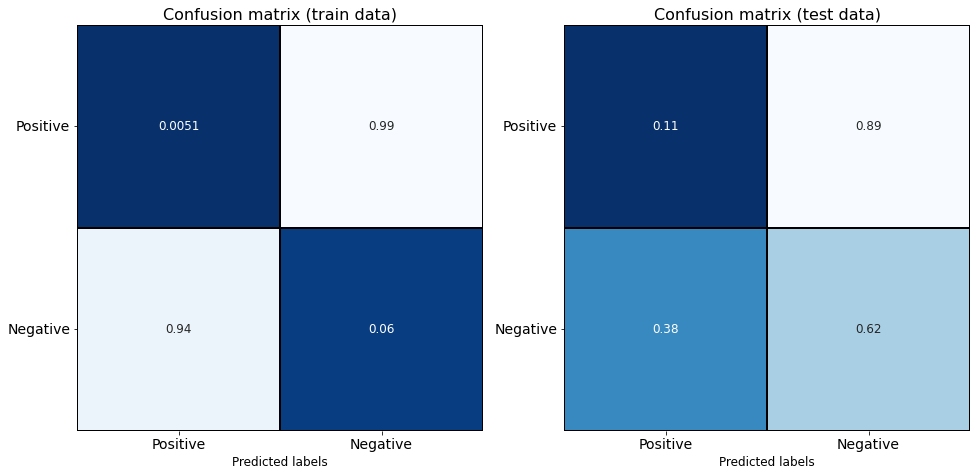

In [169]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, y_train_preds, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, y_test_preds, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])

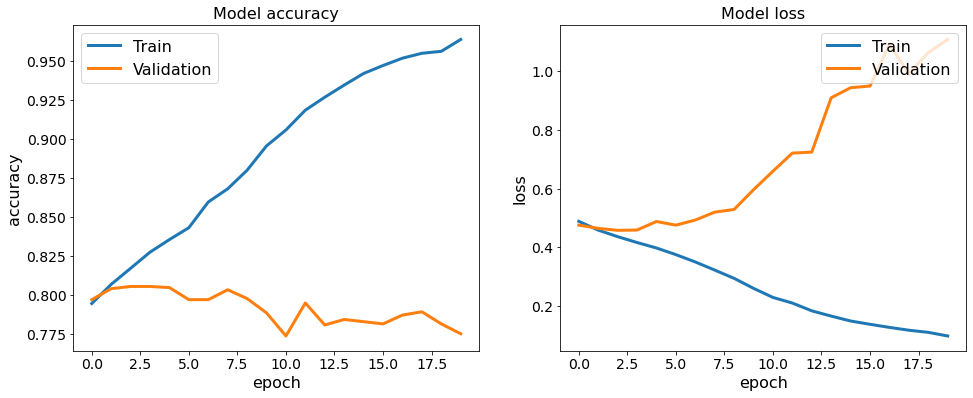

In [170]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [65]:
a=[[0.22520512], [0.9520419 ], [0.9672848 ], [0.02690617]]
np.argmax(a, axis=-1)

array([0, 0, 0, 0])